# Quick Draw

The [Google Quick Draw dataset](https://github.com/googlecreativelab/quickdraw-dataset) provides millions of vector drawings in 345 different categories. This example will work with any of the simplified binary Quick Draw datasets found [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/binary;tab=objects?prefix=). It randomly selects a quickdraw image from the first 10,000 elements in the dataset.

Example contributed by [Blair Morrison](https://github.com/blrm).

crab.bin


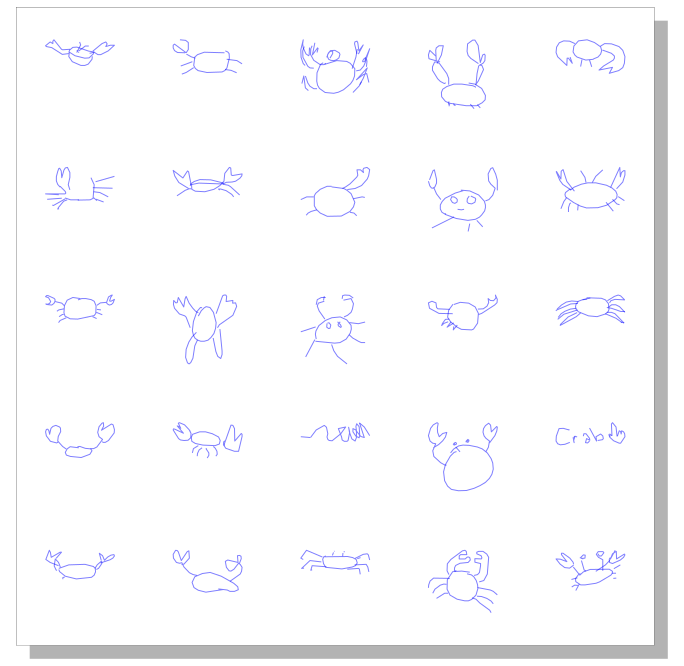

In [1]:
import random
import struct
import urllib
from itertools import islice
from struct import unpack

from shapely.geometry import MultiLineString

import vsketch


# unpacking functions are from https://github.com/googlecreativelab/quickdraw-dataset/blob/master/examples/binary_file_parser.py
def unpack_drawing(file_handle):
    (key_id,) = unpack("Q", file_handle.read(8))
    (country_code,) = unpack("2s", file_handle.read(2))
    (recognized,) = unpack("b", file_handle.read(1))
    (timestamp,) = unpack("I", file_handle.read(4))
    (n_strokes,) = unpack("H", file_handle.read(2))
    image = []
    for i in range(n_strokes):
        (n_points,) = unpack("H", file_handle.read(2))
        fmt = str(n_points) + "B"
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        "key_id": key_id,
        "country_code": country_code,
        "recognized": recognized,
        "timestamp": timestamp,
        "image": image,
    }


def unpack_drawings(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break


def quickdraw_to_linestring(qd_image):
    """Returns a Shapely MultiLineString for the provided quickdraw image.
    This MultiLineString can be passed to vsketch
    """
    linestrings = []
    for i in range(0, len(qd_image["image"])):
        line = zip(qd_image["image"][i][0], qd_image["image"][i][1])
        linestrings.append(tuple(line))
    return MultiLineString(linestrings)


# Set the quickdraw set
QUICKDRAW_SET_NAME = "crab"

quickdraw_filepath, _ = urllib.request.urlretrieve(
    f"https://storage.googleapis.com/quickdraw_dataset/full/binary/{QUICKDRAW_SET_NAME}.bin",
    f"{QUICKDRAW_SET_NAME}.bin",
)

print(quickdraw_filepath)

drawing_set = unpack_drawings(quickdraw_filepath)
drawing_subset = list(islice(drawing_set, 10000))

vsk = vsketch.Vsketch()
vsk.size("125x125mm")
vsk.penWidth("0.5mm")

# Set the dimensions of the grid
grid_size = 5

vsk.scale(1 / grid_size)
samples = random.sample(drawing_subset, grid_size ** 2)
for i in range(grid_size ** 2):
    drawing = quickdraw_to_linestring(samples[i])
    vsk.geometry(drawing)
    vsk.translate(vsk.width, 0)
    if (i + 1) % grid_size == 0:
        vsk.translate(-grid_size * vsk.width, vsk.height)

vsk.display(fig_size=(12, 12))
vsk.save(f"quick_draw_{QUICKDRAW_SET_NAME}.svg")